In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

import base
import sigGBM_generator
from utils import tosig
import importlib
importlib.reload(sigGBM_generator)

C:\Users\josep\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\josep\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\josep\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\josep\AppData\Local\Conti

<module 'sigGBM_generator' from '../src\\sigGBM_generator.py'>

# Conditional Variational Autoencoders on Geometric Brownian Motion

The **Geometric Brownian Motion (GBM)** is a continuous stochastic process often used as the standard model for stock prices where the logarithm of the performance of the stock price takes a random walk. The stochastic process $S_t$ that satisfies the stochastic differential equation given by:

$$
    dS_t = \mu S_tdt + \sigma S_t dW_t
$$

where $\mu$ is the percentage drift, $\sigma$ is the percentage volatility and $W_t$ is the Wiener process, is said to follow a GBM. Deterministic trends are modeled by the first term while the second term models the randomness of some events in motion.

Here, we use the analytic solution of the above equation starting with an inital value $S_0$:

$$
    S_t = S_0 e^{\Big(\mu - \frac{\sigma^2}{2}\Big)t + \sigma W_t}
$$

with the code defined:
```python
dt = 1. / np.sqrt(self.n_points)

timeline = np.linspace(0, 1, self.n_points)
self.windows = []
for i in range(self.n_data):
    bm = dt * np.r_[0., np.random.randn(self.n_points - 1).cumsum()]
    path = self.S0 * np.exp((self.mu - self.sigma ** 2 / 2.) * timeline + self.sigma * bm)
    self.windows.append(leadlag(path))
 ```
 
 with the process repeated until the desired amount of samples are created.

To demonstrate how this model can tackle non-stationarity of financial time series data, the generated geometric brownian motions are conditioned previous path signatures as well as starting points (in another notebook), with potential to generalise this conditioning to the other parameters of GBM.

Below, the input samples from the GBM are generated with initial parameters $\mu = 0.02, \sigma = 0.3, S_0 = [1,2,3],$ number of time steps = 20, number of samples = 220 for each $S_0$ and the signature order = 4 where signatures are explained in a later section.

In [2]:
# Signature order
order = 4

In [3]:
GB = sigGBM_generator.sigGBM(mu=0.02, sigma=0.3, S0=1, n_points = 20, n_data = 220, sig_order=order)

Computing log-signatures:   0%|          | 0/220 [00:00<?, ?it/s]

### Returns of GBM Data Sample

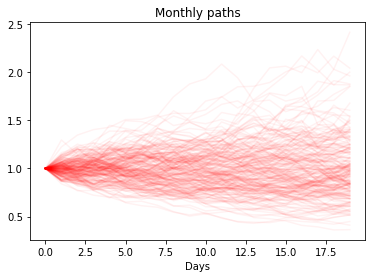

In [5]:
for path in GB.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "r", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Conditional Variational Autoencoders

Autoencoders are unsupervised neural networks that efficiently learns the best encoding-decoding such that only the important aspects of the information can propagate through and be reconstructed. A diagram of the neural network architecture is outlined below: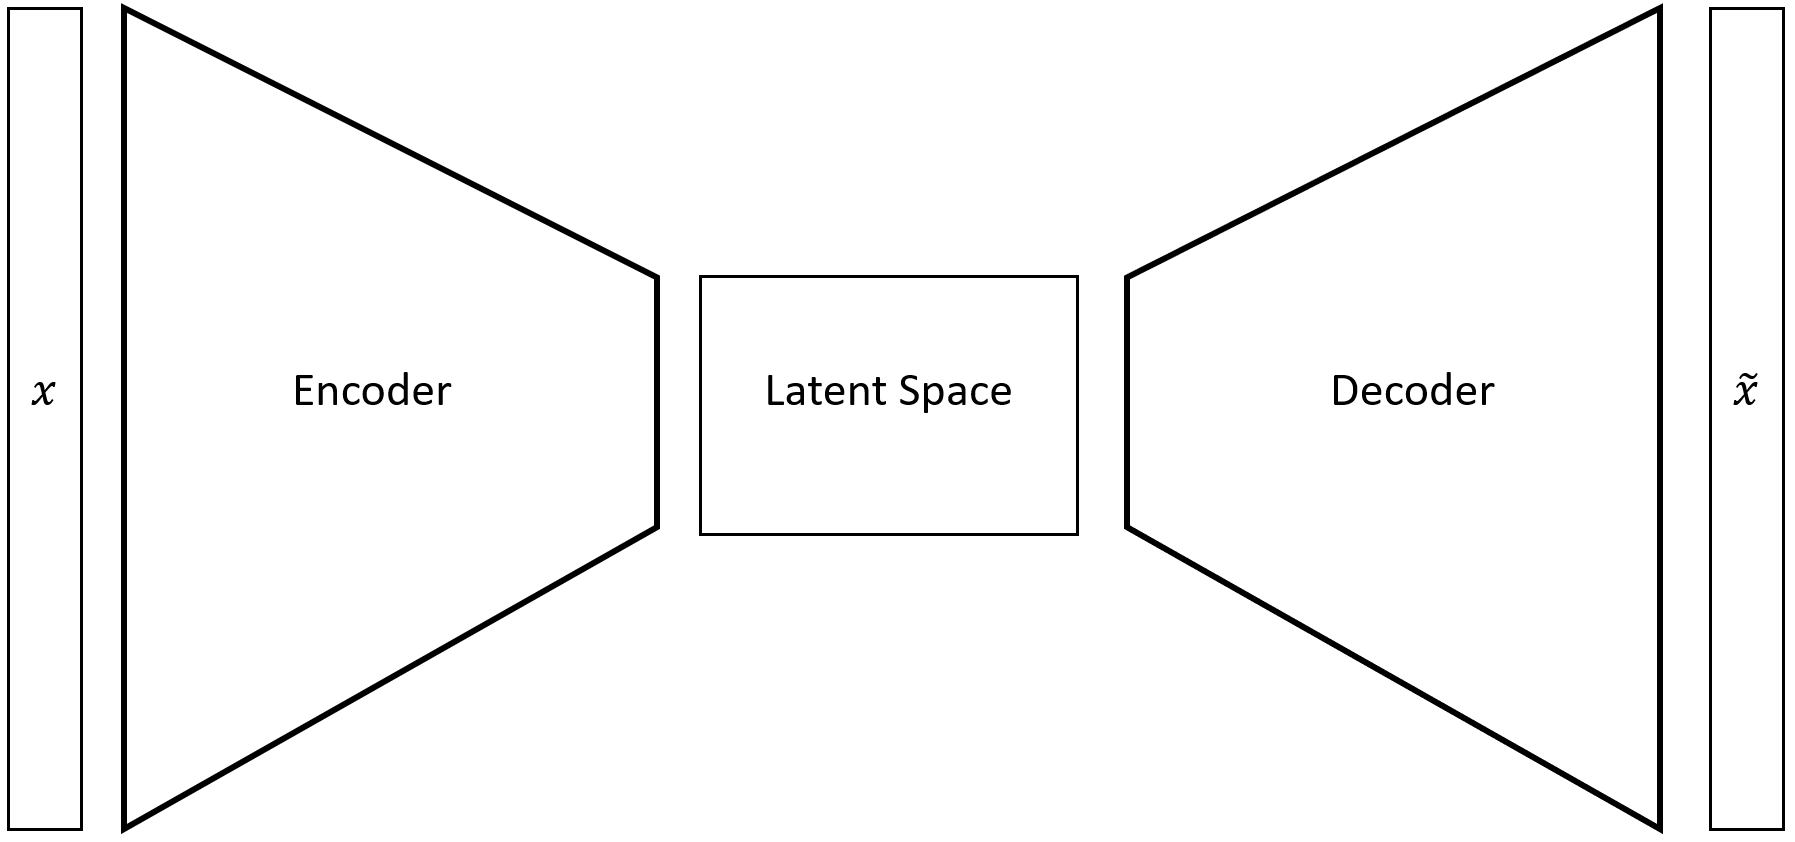 

The network architecture consists of an encoder and a decoder with $x$ as the input data to be encoded and $\tilde{x}$ as the reconstructed data after decoding. The latent space in the diagram is the representation of the compressed data which can significantly improve performance of network models and capture complexity. Autoencoders have several applications in dimensionality reduction, image compression, anomaly detection and adjustments can be made to generate time series data.

In order to repurpose the decoder to be generative, the input data is encoded as a distribution over the latent space as opposed to a single point. A point from the distribution in the latent space is subsequently decoded and the reconstruction error is computed for backpropagation through the network. Backpropagtion processes such as stochastic gradient descent can be made feasible by introducing a reparametrisation trick that slightly adjusts the variational autoencoder structure.

The latent space $z$ is assumed to be a set of multivariate Gaussian distributions with mean $\bar{x}$ and standard deviation $sd$ so $z$ can be modified as:

$$
    z = \bar{x} + sd \odot \epsilon
$$

where $\odot$ is the element wise product and $\epsilon$ is a random vector sampled from $z$. With $z$ no longer non-deterministic, it is now possible to backpropagate  $z$ as all of its elements are now known and fixed.


Finally, input data can be labeled to force a constrained representation of the learned data as a means to approach non-stationarity in financial markets through the implementation of **Conditional Variational Autoencoders (CVAE)**.

In [6]:
GB.train(n_epochs=10000)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

## Signatures

Paths are functions mapping an interval onto an $N$-dimensional Euclidean space $X : [0,T] \rightarrow \mathbb{R}^d$. However, paths are not always piecewise differentiable and rough path theory was developed to address these situations, common in financial markets.

Path signatures are a key aspect of rough path theory, encoding most crucial elements in financial market paths. The signature of a path is defined as the infinite sequence:

$$
    S(X) := (1,X^1,X^2,X^3...) \in T(\mathbb{R}^d)
$$

where:

$$
    X^n:= \int_{0<u_1<u_2<...<u_n<T} dX_{u_1} \otimes ... \otimes dX_{u_n} \in (\mathbb{R}^d)^{\otimes n} \forall n \geq 1.
$$

Although the infinite dimensional vector of signature entries fully characterises the originial path, a truncated version up to a certain order of terms still does well in encoding the original path:

$$
    S^n(X) := (1,X^1,X^2,...,X^n)
$$

where in this exercise, we use $n$ = 4 as assigned earlier. Thus, multi-dimensional time series data may be summarised with path signatures.

However, continuous paths are difficult to observe in real life and financial time series in particular are in the form of streams of data. To address this, the stream is transformed into a contintuous path using the lead-lag transformation.

Writing the data stream as:

$$
    \{(t_i, P_{t_i})\}^N_{i=0}
$$

where $P_t$ denotes the price at time $t$.

Then the lead-lag transformation of the stream is then:

\begin{align}
\hat{S}^D_t = \left\{ \begin{array}{cc} 
                (S_t,S_{t_{i+1}}) & \hspace{5mm} for\, t\in [2i,2i+1) \\
                (S_t,S_{t_{i+1}}+2(t-(2i+1))(S_{t_{i+2}}-S_{t_{i+1}}) & \hspace{5mm} for\, t\in \bigg[2i+1,2i+\frac{3}{2}\bigg) \\
                (S_{t_i}+2(t-(2i+\frac{3}{2}))(S_{t_{i+1}}-S_{t_i}),S_{t_{i+2}}) & \hspace{5mm} for\, t\in \bigg[2i+\frac{3}{2},2i+2\bigg) \\
                \end{array} \right.
\end{align}
for $t\in[0,2N]$ where $\hat{S}^D_t$ denotes the continuous version of the stream and $D$ denotes the times at which a tick is shown.

Finally, the logarithm of the signature is taken without any information loss. For the same order of the signature, the logarithm of the signature contains equal information in fewer amounts, hence representing further compression of the path.

In [ ]:
generated = np.array([GB.generate(cond) for cond in GB.conditions])
#generated = GB.generate(GB.conditions[100], n_samples=len(GB.logsigs))
#generated = GB.generate(GB.conditions[150][2] * 0.5, n_samples=len(GB.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(GB.orig_logsig)])

Even after reducing the dimensions in financial time series data, projection onto a 2-D space is still required to visualise the generated signatures.

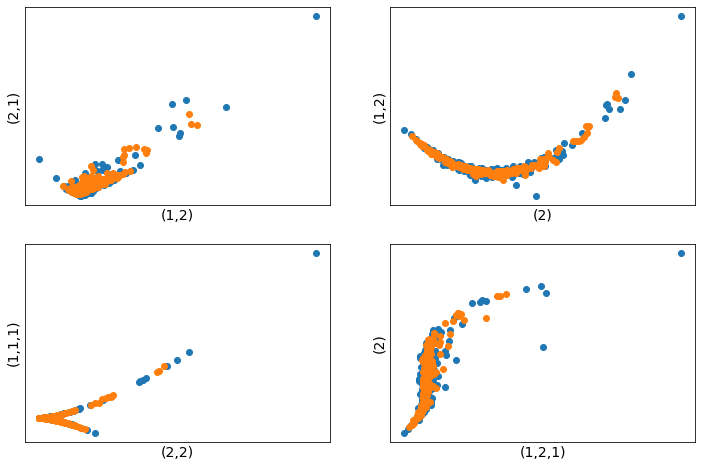

In [8]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Maximum Mean Discrepancy

The Maximum Mean Discrepancy (MMD) represents the distance between the mean embeddings of features for different distributions. The MMD describes a feature map $\phi:\chi \rightarrow \mathcal{H}$ where $\mathcal{H}$ is the kernel Hilber space, which if rich enough, can distinguish distributions. The MMD is given by:

$$
    MMD(P,Q) = ||\mathbb{E}_{\chi \thicksim P}[\phi (X)] - \mathbb{E}_{Y\thicksim Q}[\phi(Y)]||_{\mathcal{H}}
$$

where $P$ and $Q$ are distributions over a set $\chi$.

Below it is used as performance metric to compare the signatures of the generated and real data on a 99% confidence level. The hypothesis test is accepted as demonstrated by the output 'False', showing that the sets come from the same distribution.

In [9]:
import process_discriminator

normalised_generated = np.array([GB.generate(cond, normalised=True) for cond in GB.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(GB.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:11<00:00, 19.60it/s]


Computing signatures of population 1:   0%|          | 0/219 [00:00<?, ?it/s]

Computing signatures of population 2:   0%|          | 0/219 [00:00<?, ?it/s]

Are the generated and real distributions DIFFERENT? False


## Inversion of the Logarithm of the Signature

Attempting to recover the path from the logarithm of the signature is a computationally challenging task. Here, an evolutionary algorithm is used to obtain an approximation of the path.

A population of random paths are initialised and the paths with signatures nearest to the target signature are chosen, analogous to surival of the fittest in biology. These paths are bred and mutations are introduced to reproduce new paths. By the end of an adequate amount of iterations, a population of paths remains, with signatures close to the target signature to be inverted.

In [10]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag

logsig = GB.generate(GB.conditions[0])

In [11]:
pip = 0.01
n_pips = 200 * 0.1 # 50$
n_points = 21

n_iterations = 100
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

  0%|          | 0/100 [00:00<?, ?it/s]

## Bayesian Optimisation

Hyperparameter optimisation is an important aspect in training machine learning models. However, time complexity scales exponentially with dimensions, hence vanilla grid searching is often not a suitable solution for this.

One solution is to use Bayesian Optimisation which works by constructing a posterior distribution of functions that best approximates the function to be optimised. With more observations, the posterior distribution improves and the algorithm can zone into regions which are worth exploring.

Upper Confidence Bounds, UCB, are used to determine the next point that should be explored and the objective is to minimise the number of iterations required to find the optimal hyperparameters.

Furthermore, the inital boundaries of the hyperparameters may be too wide. So the domain is contracted further around the current optimal value as the search continues to considerably speed up progress. The SequentialDomainReductionTransformer can pan out and zoom in to improve convergence.

Below, an optimiser without domain reduction and with domain reduction is compared below and one can observe the fluctuations in loss for the optimiser without domain reduction compared to the one with.

In [27]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
# Bounded region of parameter space

bounds_transformer = SequentialDomainReductionTransformer()
pbounds = {'n_organisms': (90, 120), 'pip':(0.005,0.1), 'n_pips': (8,20)}

def inversionOptimization(n_organisms, pip, n_pips):
    n_organisms_integer = int(n_organisms)
    n_pips_integer = int(n_pips)
    return(-logsig_inversion.train(logsig,order,n_iterations,
                                   n_organisms_integer, n_points, pip, n_pips_integer)[1])


optimizer = BayesianOptimization(
    f=inversionOptimization,
    pbounds=pbounds,
    verbose = 2,
    random_state=1,
    bounds_transformer=bounds_transformer
)

In [28]:
optimizer.maximize(alpha=0.06)

|   iter    |  target   | n_orga... |  n_pips   |    pip    |
-------------------------------------------------------------


  0%|          | 0/101 [00:00<?, ?it/s]

|  1        | -0.1115   |  102.5    |  16.64    |  0.005011 |


  0%|          | 0/101 [00:00<?, ?it/s]

|  2        | -0.05496  |  99.07    |  9.761    |  0.01377  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  3        | -0.1385   |  95.59    |  12.15    |  0.04269  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  4        | -0.1269   |  106.2    |  13.03    |  0.0701   |


  0%|          | 0/101 [00:00<?, ?it/s]

|  5        | -0.08023  |  96.13    |  18.54    |  0.007602 |


  0%|          | 0/101 [00:00<?, ?it/s]

|  6        | -0.05382  |  98.96    |  9.85     |  0.03053  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  7        | -0.2663   |  100.1    |  10.91    |  0.05027  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  8        | -0.09615  |  98.54    |  9.249    |  0.01276  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  9        | -0.09531  |  98.18    |  10.3     |  0.01453  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  10       | -0.03675  |  99.64    |  8.981    |  0.03517  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  11       | -0.09956  |  99.99    |  8.184    |  0.02244  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  12       | -0.1421   |  100.4    |  9.181    |  0.04662  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  13       | -0.1056   |  99.17    |  8.59     |  0.04547  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  14       | -0.09963  |  99.47    |  9.386    |  0.04346  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  15       | -0.09239  |  99.8     |  8.691    |  0.02682  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  16       | -0.03541  |  98.53    |  9.726    |  0.02765  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  17       | -0.04691  |  96.81    |  9.269    |  0.02531  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  18       | -0.1377   |  97.31    |  9.445    |  0.03194  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  19       | -0.03856  |  96.59    |  9.596    |  0.02248  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  20       | -0.04903  |  98.87    |  9.368    |  0.02409  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  21       | -0.08075  |  96.96    |  10.14    |  0.02346  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  22       | -0.04499  |  98.54    |  9.72     |  0.02425  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  23       | -0.02776  |  98.64    |  10.06    |  0.02426  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  24       | -0.0837   |  98.93    |  10.35    |  0.02138  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  25       | -0.06348  |  98.14    |  9.805    |  0.02686  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  26       | -0.09144  |  98.45    |  9.976    |  0.0266   |


  0%|          | 0/101 [00:00<?, ?it/s]

|  27       | -0.03966  |  99.41    |  10.04    |  0.02216  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  28       | -0.09654  |  99.16    |  10.08    |  0.02237  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  29       | -0.03726  |  98.73    |  9.894    |  0.02256  |


  0%|          | 0/101 [00:00<?, ?it/s]

|  30       | -0.05166  |  98.67    |  10.21    |  0.02579  |


In [29]:
print(optimizer.max)

{'target': -0.027756252053865376, 'params': {'n_organisms': 98.63913893756227, 'n_pips': 10.062766571470636, 'pip': 0.024260389556028616}}


In [48]:
standard_optimizer = BayesianOptimization(
    f=inversionOptimization,
    pbounds=pbounds,
    verbose = 0,
    random_state=1,
)

In [52]:
standard_optimizer.maximize(
    init_points=2,
    n_iter=30,
)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Comparing the two optimisers, the domain reduction optimiser converges much more stably compared to the standard optimiser.

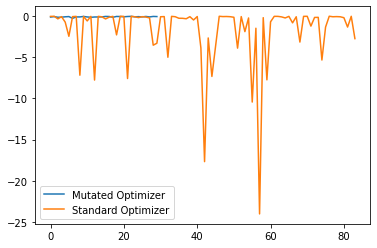

In [53]:
plt.plot(optimizer.space.target, label='Mutated Optimizer')
plt.plot(standard_optimizer.space.target, label='Standard Optimizer')
plt.legend()

In [30]:
pip = optimizer.max['params']['pip']
n_pips = int(optimizer.max['params']['n_pips'])
n_points = 21

n_iterations = 101
n_organisms = int(optimizer.max['params']['n_organisms'])

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

  0%|          | 0/101 [00:00<?, ?it/s]

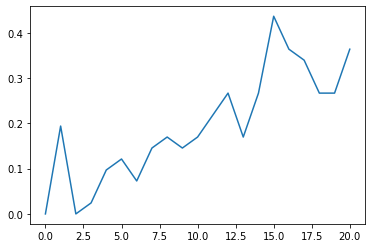

Target log-signature: [0.3463209569454193, 0.34648141264915466, -0.05679081752896309, -6.166489038150758e-05, -0.0014510559849441051, -0.00019053280993830413, -0.0003706557326950133, -0.00022068603720981628]
Recovered log-signature: [0.36390584334042936, 0.36390584334042936, -0.08210502694673161, -5.354569726440453e-05, -0.0010459259532314118, -8.539019480254025e-05, -0.0001279553882563431, -0.00021200324226837728]


In [31]:
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [32]:
paths = []
for condition in GB.conditions:
    logsig = GB.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    paths.append(recovered_path)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

After recovering the path, the returns are plotted with the real data as shown below.

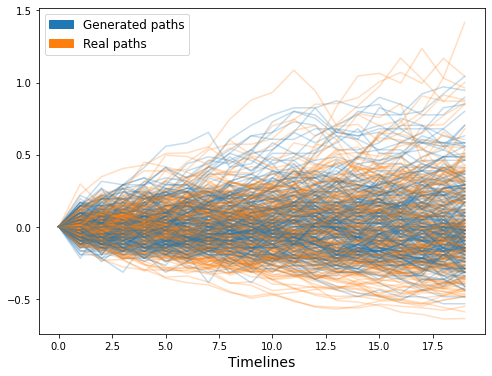

In [33]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(paths, GB.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)
plt.xlabel("Timelines", fontsize=14)
plt.show()

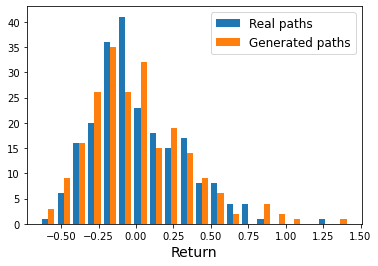

In [34]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in GB.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [35]:
from scipy.stats import skew, kurtosis
print(skew(returns1))
print(skew(returns2))
print(kurtosis(returns1))
print(kurtosis(returns2))


0.8387503470908769
1.0149138200085162
0.7348150181287036
1.7108244852308347


The paper concludes that the MMD test is sufficient as performance metric for characterising stochastic processes and does not include other tests.

For completeness, the 3rd and 4th order moments, skewness and kurtosis are calculated and presented in a table below. Moments are quantitative measures relating to the shapes of a distribution and are commonly used to evaluate tail behaviours. The general equation for standardised moments are given by:

$$
    \frac{\bar{x}_n}{sd^n} = \frac{E[(X-\bar{x})^n]}{sd^n}
$$

where n denotes the n-th ordinal of the moment.

The below table shows the results for a VAE conditioned on previous signatures:

| Dataset | Skewness | Kurtosis |
| :- | -: | :-: |
| Real | 1.01 | 0.73  |
|Sig Conditional Generated | 0.84  | 1.71 |

The same calculation was performed for a VAE conditioned on different starting points:

| Dataset | Skewness | Kurtosis |
| :- | -: | :-: |
| Real | 1.35 | 4.08  |
|Initial Conditional Generated | 0.99  | 1.98 |

The same calculation was performed for an unconditional VAE with the results shown in the table below:


| Dataset | Skewness | Kurtosis |
| :- | -: | :-: |
| Real | 0.65 | 0.14  |
|Unconditional Generated | 0.60  | -0.57 |

Encouragingly, the skewness of both datasets show a fat right tail. However, the kurtosis is quite discrepant and can be seen from the plots and distributions. The tails in the real data contain more of the distribution than the generated data.
This is reinforced by the QQ plots shown below with the generated data QQ plotted against a normal distribution showing thinner tails compared to the real distribution.

Finally, comparing the conditional and unconditional variational autoencoder, it is clear that the CVAE generates data much better, shown by the smaller discrepancy in 3rd and 4th order moments.




In [36]:
import numbers

def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):

    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]


    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.scatter(x_quantiles, y_quantiles, **kwargs)

### Real vs Generated

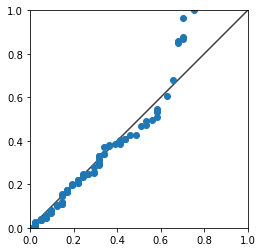

In [37]:
qqplot(returns1,returns2)

### Generated vs Normal

C:\Users\josep\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


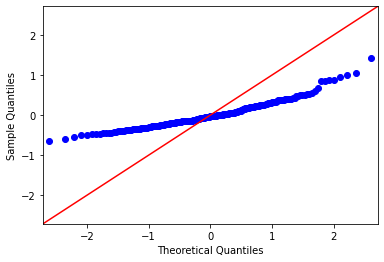

In [51]:
import statsmodels.api as sm
import pylab as py

sm.qqplot(np.array(returns2), line = '45')
py.show()

### Real vs Normal

C:\Users\josep\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


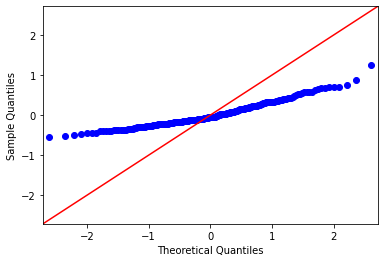

In [39]:
sm.qqplot(np.array(returns1), line = '45')
py.show()

The fact that the numbers do not align well may be due to the hyperparameters not being optimised enough for this project, Given more time, it would have been interesting to perform a more thorough grid search of some of the training parameters.

It is still positive to see that the generated data passes the MMD test and is skewed in the correct direction as well.

In [42]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = GB.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(sigGBM_generator.leadlag(recovered_path), order)
        condition = GB.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

Finally, the concatenation of paths is demonstrated below to show that a time series can be generated for longer time horizons. However, the compromise is that the longer the path, the fewer available samples.

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

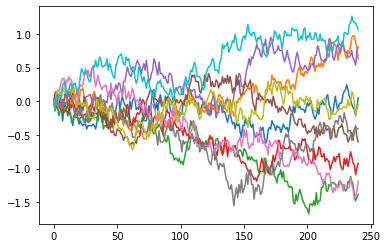

In [43]:
idx = 18

condition = GB.conditions[idx]

paths = [concatenate(condition, 12) for _ in range(10)]

plt.plot(np.transpose(paths))
plt.show()

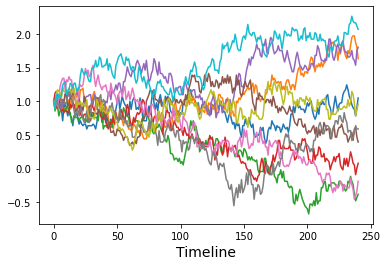

In [44]:
plt.plot(GB.windows[idx + 1][0, 0] + np.transpose(paths))
plt.xlabel("Timeline", fontsize=14) 
plt.show()